In [1]:
import pandas as pd
import numpy as np

# Загрузка и проверка чистоты данных

Загружаем данные. Для удобства понимания группу "C" везде будем называть второй А-группой, ведь по смыслу она таковой и является 

In [2]:
first_a = pd.read_csv('sample_a.csv')
second_a = pd.read_csv('sample_c.csv')
b = pd.read_csv('sample_b.csv')
prices = pd.read_csv('item_prices.csv')

In [3]:
first_a.head(5)

,user_id,item_id,action_id
0,84636,360,1
1,21217,9635,1
2,13445,8590,1
3,38450,5585,1
4,14160,2383,0


Удалим дубликаты, если они есть

In [114]:
first_a.drop_duplicates(inplace=True)
second_a.drop_duplicates(inplace=True)
b.drop_duplicates(inplace=True)

Проверим симметрично ли разделены пользователи по группам

In [407]:
print('A-1 users count:', first_a.user_id.nunique())
print('A-2 users count:', second_a.user_id.nunique())
print('B users count:', b.user_id.nunique())

A-1 users count: 996
A-2 users count: 994
B users count: 996


Достаточно симметрично

Посмотрим не пересекаются ли пользователи в разных группах

In [69]:
#check for same users in different groups
set_first = set(first_a['user_id'].values)
set_second = set(second_a['user_id'].values)
set_b = set(b['user_id'].values)
for i in set_first:
    if i in (set_second | set_b):
        print(i)

Пользователи не повторяются в разных группах.

Проверим нет ли кликов без просмотра, и покупок без просмотра

In [159]:
grouped_first = first_a.groupby(by=['user_id', 'item_id']).sum()
print('first_A_grouped: ', grouped_first.value_counts())
grouped_second = second_a.groupby(by=['user_id', 'item_id']).sum()
print('second_A_grouped: ', grouped_second.value_counts())
grouped_b = b.groupby(by=['user_id', 'item_id']).sum()
print('B_grouped: ', grouped_b.value_counts())

first_A_grouped:  action_id
1            903574
3             47556
dtype: int64
second_A_grouped:  action_id
1            892268
3             56953
dtype: int64
B_grouped:  action_id
1            856027
3             95114
dtype: int64


Нет нулей и двоек, значит нет кликов/продаж без просмотров.

No zeros and twos. It means that there are no clicks without views, and purchases without views.

# Анализ метрик "CTR", "Purchase rate"

Посчитаем 'ctr' и 'purchase rate' для каждой группы

In [4]:
first_a['action_id'].value_counts()

1    951130
0    190226
2     47556
Name: action_id, dtype: int64

In [408]:
first_counts = first_a['action_id'].value_counts()
first_ctr = first_counts[0]/first_counts[1]
first_purchase = first_counts[2]/first_counts[1]
second_counts = second_a['action_id'].value_counts()
second_ctr = second_counts[0]/second_counts[1]
second_purchase = second_counts[2]/second_counts[1]
b_counts = b['action_id'].value_counts()
b_ctr = b_counts[0]/b_counts[1]
b_purchase = b_counts[2]/b_counts[1]
print(f'A1_ctr = {first_ctr}')
print(f'A2_ctr = {second_ctr}')
print(f'b_ctr = {b_ctr}')
print(f'A1_purchase = {first_purchase}')
print(f'A2_purchase = {second_purchase}')
print(f'b_purchase = {b_purchase}')

A1_ctr = 0.2
A2_ctr = 0.20999956806686745
b_ctr = 0.16000046260228504
A1_purchase = 0.049999474309505534
A2_purchase = 0.059999726091184244
b_purchase = 0.09999989486311704


В группе "В" метрика ctr ниже обеих групп "А" (примерно на 5%). Однако purchase rate в группе "В" выше примерно в 2 раза по сравнению с группами "А". При этом обе метрики в двух "А" группах отличаются примерно на 1%. В нашем случае это может быть значимо, т.к. количество наблюдений достаточно высокое.

Проверим количество товаров в среднем показанных каждой группе

In [418]:
grouped_views_a1 = first_a[first_a['action_id']==1].groupby(by='user_id')['item_id'].count()
grouped_views_a2 = second_a[second_a['action_id']==1].groupby(by='user_id')['item_id'].count()
grouped_views_b = b[b['action_id']==1].groupby(by='user_id')['item_id'].count()
print('Среднее кол-во показаных товаров на пользователя в гр. А1:',grouped_views_a1.mean())
print('Среднее кол-во показаных товаров на пользователя в гр. А2:',grouped_views_a2.mean())
print('Среднее кол-во показаных товаров на пользователя в гр. В:',grouped_views_b.mean())

Среднее кол-во показаных товаров на пользователя в гр. А1: 954.9497991967871
Среднее кол-во показаных товаров на пользователя в гр. А2: 954.9507042253521
Среднее кол-во показаных товаров на пользователя в гр. В: 954.960843373494


Видим, что распределение показов товаров для каждой группы одинаково. Получается, что на метрики "А" групп влияние оказывает только метод отбора пользователей. 

Выполним статистический тест, для сравнения двух "А" групп

In [446]:
from statsmodels.stats.weightstats import ztest

tstat, pvalue = ztest(first_a['action_id'], second_a['action_id'])
print('t-stat:', tstat)
print('p-value:', pvalue)

t-stat: -3.336163638995584
p-value: 0.0008494314889001632


P-value меньше 0.01, таким образом с большой долей вероятности можно сказать что две группы "А" взяты из разных распределений (отобраны не совсем корректно).

# Метрика "GMV"

Оценим продажи по группам в абсолютных величинах

In [404]:
print('Количество совершенных покупок в группе А-1:',first_a[first_a['action_id']==2]['item_id'].count())
print('Количество совершенных покупок в группе А-2:',second_a[second_a['action_id']==2]['item_id'].count())
print('Количество совершенных покупок в группе B:',b[b['action_id']==2]['item_id'].count())

Количество совершенных покупок в группе А-1: 47556
Количество совершенных покупок в группе А-2: 56953
Количество совершенных покупок в группе B: 95114


При первом взгляде на продажи, даже без учета цен, заметна существенная разница между группами по количеству продаж. Между двумя "А"-группами разница составляет около 20%. Группа "В" же больше первой группы "А" в два раза, и на 80% больше второй "А" группы.

Добавим теперь в датасет каждой группы цену товара и сравним результат в денежном выражении

In [356]:
pairs = prices.apply(lambda x: [x['item_id'], x['item_price']], axis=1)

prices_dict = {}
for i in pairs:
    prices_dict[i[0]] = i[1]
    
first_a['price'] = first_a['item_id'].apply(lambda x: prices_dict[x])
second_a['price'] = second_a['item_id'].apply(lambda x: prices_dict[x])
b['price'] = b['item_id'].apply(lambda x: prices_dict[x])

Посчитаем метрику gmv для каждой группы

In [344]:
gmv_a1 = first_a[first_a['action_id']==2].groupby(by='user_id')['price'].sum()
gmv_a2 = second_a[second_a['action_id']==2].groupby(by='user_id')['price'].sum()
gmv_b = b[b['action_id']==2].groupby(by='user_id')['price'].sum()

Посмотрим на графике как распределены покупки пользователей в каждой группе

<AxesSubplot:ylabel='Frequency'>

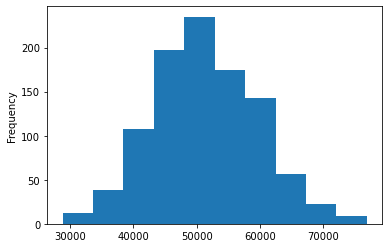

In [449]:
gmv_a1.plot(kind='hist')

<AxesSubplot:ylabel='Frequency'>

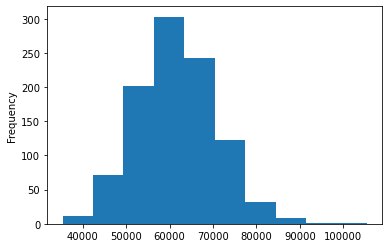

In [450]:
gmv_a2.plot(kind='hist')

<AxesSubplot:ylabel='Frequency'>

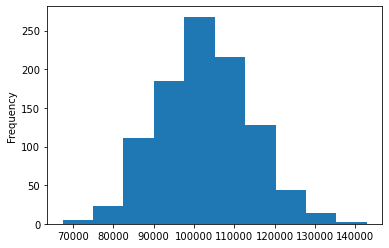

In [387]:
gmv_b.plot(kind='hist')

Видим что в ценовом выражении данные из каждой группы также заметно отличаются. Средний чек в группе "А-2" на 10 000 больше чем в группе "А-1". В группе "В" при этом средний чек в 2 раза больше чем в "А-1".
Во всех группах данные визуально распределены нормально, возможно только в группе "А-2" есть небольшой правый хвост. Проверим гипотезу о нормальности распределения тестом Шапиро-Уилка, при уровне значимости p-value=0.01

In [459]:
from scipy.stats import shapiro

print('A-1 group, test Shapiro p-value =',shapiro(gmv_a1)[1])
print('A-2 group, test Shapiro p-value =',shapiro(gmv_a2)[1])
print('B group, test Shapiro p-value =',shapiro(gmv_b)[1])

A-1 group, test Shapiro p-value = 0.04304099082946777
A-2 group, test Shapiro p-value = 0.005459895357489586
B group, test Shapiro p-value = 0.6805786490440369


 Для группы "А-2" гипотеза о нормальности распределения данных отвергается, т.к. p-value < 0.01, впрочем мы так и предполагали судя по правому хвосту на графике.
 Попробуем нормализовать эти данные взяв квадратный корень

square-root A-2 group, test Shapiro p-value = 0.4086432456970215


<AxesSubplot:ylabel='Frequency'>

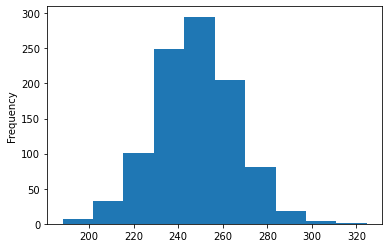

In [462]:
print('square-root A-2 group, test Shapiro p-value =',shapiro(np.sqrt(gmv_a2))[1])
np.sqrt(gmv_a2).plot(kind='hist')

Теперь данные соответствуют характеристике нормального распределения. Можем сравнить их с другой "А" группой, а также с тестовой группой, хотя и без статистического теста заметно что группа "В" значительно отличается от двух "А"-групп.  

Сравнивать будем корни значений групп

In [467]:
AA_test = ztest(np.sqrt(gmv_a1), np.sqrt(gmv_a2))
AB_test = ztest(np.sqrt(gmv_a1), np.sqrt(gmv_b))
BA_test = ztest(np.sqrt(gmv_b), np.sqrt(gmv_a2))
print('p-value для двух А групп:', AA_test[1])
print('p-value при сравнении А-1 и В группы:', AB_test[1])
print('p-value при сравнении А-2 и В группы:', BA_test[1])

p-value для двух А групп: 4.62982143106317e-153
p-value при сравнении А-1 и В группы: 0.0
p-value при сравнении А-2 и В группы: 0.0


Как видно из статистического теста, данные во всех группах получены из разных распределений, p-value везде значительно ниже 0.05, что подтверждает предположение о неправильном разбиении "А"-групп.

В конце сравним суммарный оборот каждой группы

In [476]:
print('выручка A-1 группы:',gmv_a1.sum())
print('выручка A-2 группы:',gmv_a2.sum())
print('выручка В группы:',gmv_b.sum())

выручка A-1 группы: 51183991
выручка A-2 группы: 61236564
выручка В группы: 102261317


Общая выручка по группам отличается в таком же соотношении как средний чек в каждой группе. Группа "В" заметно более прибыльная.

# Вывод

После анализа данных, полученных после проведения А/А/В теста, замечено, что тестовая группа "В" заметно превосходит группы "А" по показателям прибыльности. Для бизнеса, изменения которые тестировались на группе "В", явно пойдут на пользу, если только целью изменений не было увеличения количества кликов на товар. Так, выручка и средний чек в группе "В" приблизительно в 2 раза выше этих показателей групп "A". 

Однако при анализе обнаружилось, что средние показатели данных в двух "А" группах имеют статистически значимые отличия, такого быть не должно. Это свидетельствует о некорректной работе алгоритма распределения пользователей по группам и требует его настройки либо замены.

При этом результат теста я бы всё равно считал положительным, т.к. группа "В" имеет значительное преимущество над обеими "А" группами, гораздо большее чем эти группы различаются между собой вследствие их неверного распределения.